# **Face Recognition using Face Images obtained from the internet**
The objective of this project is to implement an accurate face recognition model for a custom dataset


In [2]:
# Common
import os
import cv2 as cv
import numpy as np
from IPython.display import clear_output as cls

# Data 
from tqdm.notebook import tqdm
from glob import glob

# Data Visuaalization
import plotly.express as px
import matplotlib.pyplot as plt

In [3]:
# Setting a random
np.random.seed(42)

# Define the image dimensions
IMG_W, IMG_H, IMG_C = (112, 112, 3)

# **Data Loading**
---

In [4]:
# Specify the root directory path
root_path = 'datasets/train/'

# Collect all the person names
dir_names = os.listdir(root_path)

person_names = [name for name in dir_names]
n_individuals = len(person_names)

print(f"Total number of individuals: {n_individuals}\n")
print(f"Name of the individuals : \n\t{person_names}")

Total number of individuals: 250

Name of the individuals : 
	['aaron_finch', 'abhay_deol', 'adam_zampa', 'adil_hussain', 'adil_rashid', 'ajay_devgn', 'akshaye_khanna', 'akshay_kumar', 'alex_carey', 'amitabh_bachchan', 'amjad_khan', 'amole_gupte', 'amol_palekar', 'amrish_puri', 'andre_russell', 'angelo_mathews', 'anil_kapoor', 'annu_kapoor', 'anrich_nortje', 'anupam_kher', 'anushka_shetty', 'arshad_warsi', 'aruna_irani', 'ashish_vidyarthi', 'asrani', 'Associate_Prof_Chester_Rebeiro', 'Associate_prof_LA_Prashanth', 'Associate_Prof_Manikandan_Narayanan', 'Associate_prof_Meghana_Nasre', 'Associate_prof_Raghavendra_Rao', 'Associate_Prof_Rupesh_Nasre', 'Asst_prof_Aishwarya_Thiruvengadam', 'Asst_prof_Arun_Rajkumar', 'Asst_prof_Ayon_Chakraborty', 'Asst_prof_Chandrashekar_Lakshminarayanan', 'Asst_Prof_Harish_Guruprasad', 'Asst_prof_Kartik_Nagar', 'Asst_Prof_Mitesh_Khapra', 'Asst_prof_Nishad_Kothari', 'Asst_Prof_Yadu_Vasudev', 'atul_kulkarni', 'avishka_fernando', 'ayushmann_khurrana', 'babar_az

In [5]:
# Number of images available per person
name = dir_names[0]

n_images_per_person = [len(os.listdir(root_path + name)) for name in dir_names]
n_images = sum(n_images_per_person)

# Show
print(f"Total Number of Images : {n_images}.")

Total Number of Images : 6683.


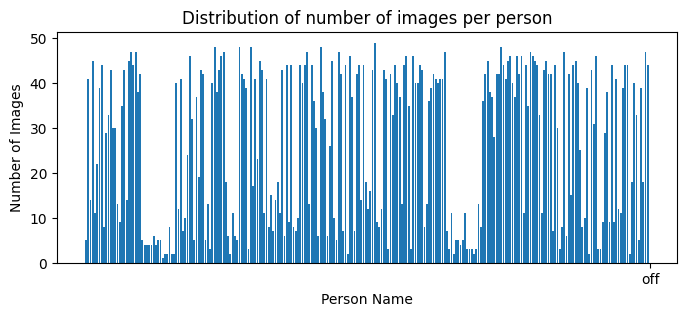

In [6]:
# Plot the Distribution of number of images per person.
plt.figure(figsize=(8, 3))
plt.bar(person_names, n_images_per_person)
plt.title("Distribution of number of images per person")
plt.xlabel("Person Name")
plt.ylabel("Number of Images")
plt.xticks('off')
plt.show()

In [ ]:
# Select all the file paths : 50 images per person.
filepaths = [path  for name in dir_names for path in glob(root_path + name + '/*')[:50]]
np.random.shuffle(filepaths)
print(f"Total number of images to be loaded : {len(filepaths)}")

# Create space for the images
all_images = np.empty(shape=(len(filepaths), IMG_W, IMG_H, IMG_C), dtype = np.float32)
all_labels = np.empty(shape=(len(filepaths), 1), dtype = np.int32)

# For each path, load the image and apply some preprocessing.
for index, path in enumerate(tqdm(filepaths)):
    
    # Extract label
    label = [name for name in dir_names if name in path][0]
    label = person_names.index(label)
    
    # Load the Image
    image = plt.imread(path)
    
    # Resize the image
    image = cv.resize(image, dsize = (IMG_W, IMG_H))
    
    # Convert image stype
    image = image.astype(np.float32)/255.0
    
    # Store the image and the label
    all_images[index] = image
    all_labels[index] = label

# **Data Visualization**
---

In [7]:
def show_data(
    images: np.ndarray, 
    labels: np.ndarray,
    GRID: tuple=(15,6),
    FIGSIZE: tuple=(25,50), 
    recog_fn = None,
    database = None
) -> None:

    # Plotting Configuration
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    
    # loop over the images and labels
    for index in range(n_images):
        
        # Select image in the corresponding label randomly
        image_index = np.random.randint(len(images))
        image, label = images[image_index], person_names[int(labels[image_index])]
        
        # Create a Subplot
        plt.subplot(n_rows, n_cols, index+1)
        
        # Plot Image
        plt.imshow(image)
        plt.axis('off')
        
        if recog_fn is None:
            # Plot title
            plt.title(label)
        else:
            recognized = recog_fn(image, database)
            plt.title(f"True:{label}\nPred:{recognized}")
    
    # Show final Plot
    plt.tight_layout()
    plt.show()

In [ ]:
show_data(images = all_images, labels = all_labels)

# **Create Model**
---

In [ ]:
from tensorflow.python.keras.engine import training
from tensorflow import keras
from keras.layers import (
    ZeroPadding2D,
    Input,
    Conv2D,
    BatchNormalization,
    PReLU,
    Add,
    Dropout,
    Flatten,
    Dense,
)

# Load the model
def loadModel(file_path="arcface_weights.h"):

    base_model = ResNet34()
    inputs = base_model.inputs[0]
    arcface_model = base_model.outputs[0]
    arcface_model = BatchNormalization(momentum=0.9, epsilon=2e-5)(arcface_model)
    arcface_model = Dropout(0.4)(arcface_model)
    arcface_model = Flatten()(arcface_model)
    arcface_model = Dense(
        512, activation=None, use_bias=True, kernel_initializer="glorot_normal"
    )(arcface_model)
    embedding = BatchNormalization(
        momentum=0.9, epsilon=2e-5, name="embedding", scale=True
    )(arcface_model)

    # Create the model
    model = keras.models.Model(inputs, embedding, name=base_model.name)

    # Load the weights
    model.load_weights(file_path)

    return model


def ResNet34():
    img_input = Input(shape=(112, 112, 3))

    x = ZeroPadding2D(padding=1, name="conv1_pad")(img_input)
    x = Conv2D(
        64,
        3,
        strides=1,
        use_bias=False,
        kernel_initializer="glorot_normal",
        name="conv1_conv",
    )(x)
    x = BatchNormalization(axis=3, epsilon=2e-5, momentum=0.9, name="conv1_bn")(x)
    x = PReLU(shared_axes=[1, 2], name="conv1_prelu")(x)
    x = stack_fn(x)

    # Create model.
    model = training.Model(img_input, x, name="ResNet34")

    return model


def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    bn_axis = 3

    # if conv_shortcut is True, apply convolutional layer to the shortcut
    if conv_shortcut:
        shortcut = Conv2D(
            filters,
            1,
            strides=stride,
            use_bias=False,
            kernel_initializer="glorot_normal",
            name=name + "_0_conv",
        )(x)
        shortcut = BatchNormalization(
            axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + "_0_bn"
        )(shortcut)
    else:
        shortcut = x

    x = BatchNormalization(
        axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + "_1_bn"
    )(x)
    x = ZeroPadding2D(padding=1, name=name + "_1_pad")(x)
    x = Conv2D(
        filters,
        3,
        strides=1,
        kernel_initializer="glorot_normal",
        use_bias=False,
        name=name + "_1_conv",
    )(x)
    x = BatchNormalization(
        axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + "_2_bn"
    )(x)
    x = PReLU(shared_axes=[1, 2], name=name + "_1_prelu")(x)

    x = ZeroPadding2D(padding=1, name=name + "_2_pad")(x)
    x = Conv2D(
        filters,
        kernel_size,
        strides=stride,
        kernel_initializer="glorot_normal",
        use_bias=False,
        name=name + "_2_conv",
    )(x)
    x = BatchNormalization(
        axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + "_3_bn"
    )(x)

    x = Add(name=name + "_add")([shortcut, x])
    return x


def stack1(x, filters, blocks, stride1=2, name=None):
    x = block1(x, filters, stride=stride1, name=name + "_block1")
    for i in range(2, blocks + 1):
        x = block1(x, filters, conv_shortcut=False, name=name + "_block" + str(i))
    return x


def stack_fn(x):
    x = stack1(x, 64, 3, name="conv2")
    x = stack1(x, 128, 4, name="conv3")
    x = stack1(x, 256, 6, name="conv4")
    return stack1(x, 512, 3, name="conv5")

# **Face Database**
---

In [9]:
def load_image(image_path: str, IMG_W: int = IMG_W, IMG_H: int = IMG_H) -> np.ndarray:    
    # Load the image
    image = plt.imread(image_path)
    
    # Resize the image
    image = cv.resize(image, dsize=(IMG_W, IMG_H))
    
    # Convert image type and normalize pixel values
    image = image.astype(np.float32) / 255.0
    
    return image

def image_to_embedding(image: np.ndarray, model) -> np.ndarray:
    # Obtain image encoding
    embedding = model.predict(image[np.newaxis,...], verbose=False)

    # Normalize bedding using L2 norm.
    embedding /= np.linalg.norm(embedding, ord=2)
    
    # Return embedding
    return embedding
    
def generate_avg_embedding(image_paths: list, model) -> np.ndarray:    
    # Collect embeddings
    embeddings = np.empty(shape=(len(image_paths), 512))
    
    # Loop over images
    for index, image_path in enumerate(image_paths):
        
        # Load the image
        image = load_image(image_path)
        
        # Generate the embedding
        embedding = image_to_embedding(image, model)
        
        # Store the embedding
        embeddings[index] = embedding
        
    # Compute average embedding
    avg_embedding = np.mean(embeddings, axis=0)
    
    # Clear Output
    # cls()
    
    # Return average embedding
    return avg_embedding

In [ ]:
# Load model
model = loadModel('arcface_weights.h5')
model.summary()

In [ ]:
# Select all the file paths : minimu of 10 or count of images per person.
filepaths = [np.random.choice(glob(root_path + name + '/*'), size=min(10, len(glob(root_path + name + '/*'))), replace=False) for name in dir_names]

# Create data base
database = {name:generate_avg_embedding(paths, model=model) for paths, name in tqdm(zip(filepaths, person_names), desc="Generating embedding")}


# Save database to disk
np.save("database.npy", database)

In [92]:
# Load database from disk
database = np.load("database.npy", allow_pickle=True).item()

# **Face Recognition**
---

In [12]:
def compare_embeddings(embedding_1: np.ndarray, embedding_2: np.ndarray, threshold: float = 0.8) -> int:
    # Calculate the distance between the embeddings
    embedding_distance = embedding_1 - embedding_2

    # Calculate the L2 norm of the distance vector
    embedding_distance_norm = np.linalg.norm(embedding_distance)

    # Return 1 if the distance is less than the threshold, else 0
    return embedding_distance_norm if embedding_distance_norm < threshold else 0

In [13]:
def recognize_face(image: np.ndarray, database: dict, threshold: float = 1.0, model = model) -> str:
    # Generate embedding for the new image
    image_emb = image_to_embedding(image, model)
    
    # Clear output
    # cls()
    
    # Store distances
    distances = []
    names = []
    
    # Loop over database
    for name, embed in database.items():
        
        # Compare the embeddings
        dist = compare_embeddings(embed, image_emb, threshold=threshold)

        if dist > 0:
            # Append the score
            distances.append(dist)
            names.append(name)

    # Select the min distance
    if distances:
        min_dist = min(distances)
        # print(distances)
        return names[distances.index(min_dist)].title().strip(), 1 - min_dist
    
    return "No Match Found", 0.0

In [14]:
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_face(image):

    # Convert the image to grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # Extract the face region
    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]

        # Resize the face to 100x100
        resized_face = cv.resize(face, (112, 112))
        return resized_face

# **Web Scraping**
----

In [ ]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from tqdm.notebook import tqdm

def download_image(base_url, url, folder, filename):
    try:
        # Construct the complete URL
        complete_url = urljoin(base_url, url)

        image_data = requests.get(complete_url).content
        with open(os.path.join(folder, f"{filename}.jpg"), 'wb') as handler:
            handler.write(image_data)
        return os.path.join(folder, f"{filename}.jpg")
    except Exception as e:
        print(f"Error downloading image {url}: {e}")
        return None

def scrape_images(url, output_folder):
    # Send a GET request to the URL
    response = requests.get(url)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all img tags in the HTML
    img_tags = soup.find_all('img')

    # Download and save each image
    for i, img_tag in enumerate(tqdm(img_tags)):
        img_url = img_tag['src']
        image_path = download_image(url, img_url, output_folder, f"image_{i + 1}")

        # Print the path to the downloaded image
        if image_path:
            print(f"Image {i + 1} saved at {image_path}")

# Example usage
website_url = 'https://publications.iitm.ac.in/unit/department/department-of-computer-science-and-engineering/profiles'
output_folder = 'output_images1'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scrape_images(website_url, output_folder)

# **Predicting and displaying results**
---

In [ ]:
# Load images from datasets/test folder
test_folder = "TPA2_Face_Recognition-20231127T102046Z-001/TPA2_Face_Recognition/"
test_images = []
for filename in os.listdir(test_folder):
    
    # Read the image and convert to RGB
    img = cv.imread(os.path.join(test_folder, filename))
    if img is None:
        continue
    
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    if img is not None:
        test_images.append(img)


print("Number of test images loaded: ", len(test_images))


fig = plt.figure(figsize=(30, 20))
# rows = 5

faces = []
predicted_names = []
confidence_scores = []

for i, img in enumerate(tqdm(test_images)):
    # Extract the face and resize it to 112x112
    resized_face = extract_face(img)
    if resized_face is None:
        continue
    resized_face = cv.resize(resized_face, (IMG_W, IMG_H))
    # resized_face = cv.cvtColor(resized_face, cv.COLOR_BGR2RGB)
    resized_face = resized_face.astype(np.float32)/255.0

    # Recognize the face in the image
    title, confidence = recognize_face(resized_face, database)
    # print(str(confidence * 100))
    faces.append((resized_face * 255.0).astype(np.uint8))
    predicted_names.append(title)
    confidence_scores.append(str(round(confidence * 100, 2)))



In [ ]:
columns = 3
rows = len(predicted_names) + 1

# Calculate figure size from image sizes
fig_width = 12
fig_height = rows * fig_width * 0.15

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
i = 0

# PLot the above images in table 
for y in tqdm(range(len(faces))):
    # face = cv.cvtColor(faces[y], cv.COLOR_BGR2RGB)
    # Plot the images
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(faces[y])
    if i == 0:
        plt.title("Face", fontsize=10, pad=20)
    plt.axis("off")

    # Plot the names
    fig.add_subplot(rows, columns, i + 2)
    blank_image = np.ones((112, 280, 3), np.uint8) * 255
    cv.putText(blank_image, predicted_names[y], (0, 50), cv.FONT_HERSHEY_SIMPLEX, 0.6, (25, 25, 25), 1)
    plt.imshow(blank_image)
    if i == 0:
        plt.title("Predicted Name", fontsize=10, pad=20)
    plt.axis("off")

    # Plot the scores
    fig.add_subplot(rows, columns, i + 3)
    blank_image = np.ones((112, 112, 3), np.uint8) * 255
    cv.putText(blank_image, str(confidence_scores[y]), (0, 50), cv.FONT_HERSHEY_SIMPLEX, 0.6, (25, 25, 25), 1)
    if i == 0:
        plt.title("Confidence Score", fontsize=10, pad=20)
    plt.imshow(blank_image)
    plt.axis("off")

    i += 3

ax.axis('off')
plt.grid(False)
plt.show()

# **Testing on random samples**
---

In [ ]:
# Randomly select an index
index = np.random.randint(len(all_images))

# Obtain an image and its corresponding label
image_ = all_images[index]
label_ = person_names[int(all_labels[index])]

# Recognize the face in the image
title, confidence = recognize_face(image_, database)

# Plot the image along with its true and predicted labels
plt.figure(figsize=(2, 2)) 
plt.imshow(image_)
plt.title(f"True:{label_}\nPred:{title} {round(confidence * 100, 2)}%")
plt.axis('off')
plt.show()

In [ ]:
# Count the number of images
n_images = 100

# Initialize the number of correct predictions
n_correct = 0

# Randomly Select images
indicies = np.random.permutation(n_images)
temp_images = all_images[indicies]
temp_labels = all_labels[indicies]

# Iterate over each image and its corresponding label
for (image, label) in tqdm(zip(temp_images, temp_labels)):
    
    # Extract the true label of the person in the image
    true_label = person_names[int(label)]

    # Use the recognize_face function to predict the label of the person in the image
    pred_label, _ = recognize_face(image, database)

    # If the true label and the predicted label match, increment the number of correct predictions
    # print(true_label.title(), pred_label)
    if true_label.title() == pred_label:
        n_correct += 1
    else:
        plt.figure(figsize=(2, 2))
        plt.imshow(image)
        plt.title(f"True:{true_label}\nPred:{pred_label}")
        plt.axis('off')
        plt.show()



# Calculate the accuracy of the model
acc = (n_correct / n_images) * 100.0

# Print the accuracy of the model
print(f"Model Accuracy: {acc}%!!!")